## Loading Libraries


In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
import tensorflow as keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [2]:
### We create a bunch of helpful functions throughout the course.
### Storing them here so they're easily accessible.

import tensorflow as tf

# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).
  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.
  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.
  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.
  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")
  
# Make a function to predict on images and plot them (works with multi-class)
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);
  
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.
  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"
  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Plot the validation and training data separately
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.
    
    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here) 
    """
    
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
  
# Create function to unzip a zipfile into current working directory 
# (since we're going to be downloading and unzipping a few files)
import zipfile

def unzip_data(filename):
  """
  Unzips filename into the current working directory.
  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
import os

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array
  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

## Load and Transform Data

In [3]:
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = (300, 300)

In [5]:
# Walk through each directory
dataset = r"D:\COllege\CapStone\DataSet\Merged_Medicinal_Plant_dataset"
walk_through_dir(dataset);

There are 79 directories and 0 images in 'D:\COllege\CapStone\DataSet\Merged_Medicinal_Plant_dataset'.
There are 0 directories and 66 images in 'D:\COllege\CapStone\DataSet\Merged_Medicinal_Plant_dataset\Abrus Precatorius (Rosary Pea)'.
There are 0 directories and 124 images in 'D:\COllege\CapStone\DataSet\Merged_Medicinal_Plant_dataset\Acalypha Indica (Indian CopperLeaf)'.
There are 0 directories and 54 images in 'D:\COllege\CapStone\DataSet\Merged_Medicinal_Plant_dataset\Achyranthes Aspera (Prickly Chaff Flower)'.
There are 0 directories and 75 images in 'D:\COllege\CapStone\DataSet\Merged_Medicinal_Plant_dataset\Acorus Calamus (Sweet flag)'.
There are 0 directories and 78 images in 'D:\COllege\CapStone\DataSet\Merged_Medicinal_Plant_dataset\Aerva Lanata (Mountain Knotgrass)'.
There are 0 directories and 50 images in 'D:\COllege\CapStone\DataSet\Merged_Medicinal_Plant_dataset\Alpinia Galanga (Rasna)'.
There are 0 directories and 125 images in 'D:\COllege\CapStone\DataSet\Merged_Medic

### Placing data into a Dataframe

In [6]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [7]:
image_df

,Filepath,Label
0,D:\COllege\CapStone\DataSet\Merged_Medicinal_P...,Abrus Precatorius (Rosary Pea)
1,D:\COllege\CapStone\DataSet\Merged_Medicinal_P...,Abrus Precatorius (Rosary Pea)
2,D:\COllege\CapStone\DataSet\Merged_Medicinal_P...,Abrus Precatorius (Rosary Pea)
3,D:\COllege\CapStone\DataSet\Merged_Medicinal_P...,Abrus Precatorius (Rosary Pea)
4,D:\COllege\CapStone\DataSet\Merged_Medicinal_P...,Abrus Precatorius (Rosary Pea)
...,...,...
11123,D:\COllege\CapStone\DataSet\Merged_Medicinal_P...,Ziziphus Mauritiana (Indian Jujube)
11124,D:\COllege\CapStone\DataSet\Merged_Medicinal_P...,Ziziphus Mauritiana (Indian Jujube)
11125,D:\COllege\CapStone\DataSet\Merged_Medicinal_P...,Ziziphus Mauritiana (Indian Jujube)
11126,D:\COllege\CapStone\DataSet\Merged_Medicinal_P...,Ziziphus Mauritiana (Indian Jujube)


### Visualizing images from the dataset

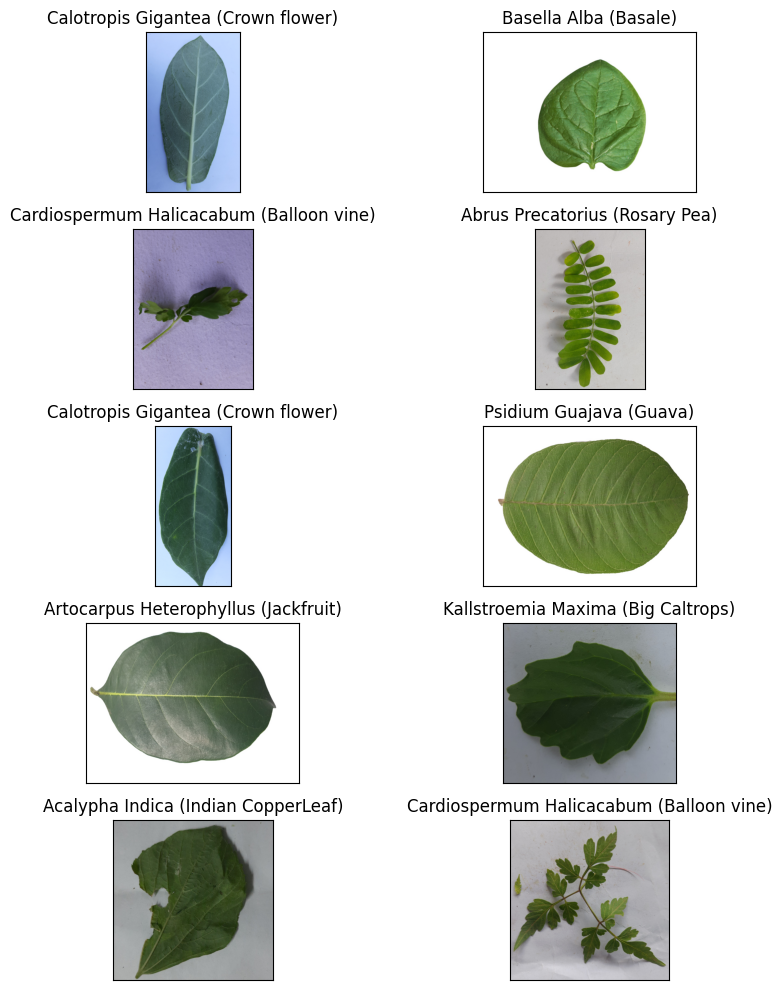

In [8]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 10)
fig, axes = plt.subplots(nrows= 5, ncols=2, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

### Data Preprocessing

In [9]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [10]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [11]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 7122 validated image filenames belonging to 79 classes.
Found 1780 validated image filenames belonging to 79 classes.
Found 2226 validated image filenames belonging to 79 classes.


In [12]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Training the model

In [13]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [14]:
# Create checkpoint callback
checkpoint_path = "plant_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [15]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

In [16]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)


outputs = Dense(79, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=10,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "plant_classification"),
        checkpoint_callback,
    ]
)


Saving TensorBoard log files to: training_logs/plant_classification/20230412-180503


C:\Users\appud\anaconda3\envs\prpject_new_env_v1\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/10
223/223 [==============================] - 457s 2s/step - loss: 3.7192 - accuracy: 0.1660 - val_loss: 2.5055 - val_accuracy: 0.4921
Epoch 2/10
223/223 [==============================] - 376s 2s/step - loss: 2.0911 - accuracy: 0.4971 - val_loss: 1.1073 - val_accuracy: 0.8124
Epoch 3/10
223/223 [==============================] - 283s 1s/step - loss: 1.2141 - accuracy: 0.7020 - val_loss: 0.6196 - val_accuracy: 0.8972
Epoch 4/10
223/223 [==============================] - 148s 664ms/step - loss: 0.8285 - accuracy: 0.7894 - val_loss: 0.4214 - val_accuracy: 0.9298
Epoch 5/10
223/223 [==============================] - 144s 646ms/step - loss: 0.6119 - accuracy: 0.8467 - val_loss: 0.3161 - val_accuracy: 0.9433
Epoch 6/10
223/223 [==============================] - 132s 592ms/step - loss: 0.4852 - accuracy: 0.8805 - val_loss: 0.2519 - val_accuracy: 0.9522
Epoch 7/10
223/223 [==============================] - 133s 595ms/step - loss: 0.3999 - accuracy: 0.9014 - val_loss: 0.2051 - val_accu

### Saving Model


In [17]:
#model.save('Herb_Prediction_MobileNetV2__MergedDATA.h5')

In [18]:
#model.summary()

### Loading the PreTrained Model

In [19]:
# model = tf.keras.models.load_model('Herb_Prediction_MobileNetV2__MergedDATA.h5')
# Check its architecture
#model.summary()

### Model Evaluation

In [20]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.15064
Test Accuracy: 96.50%


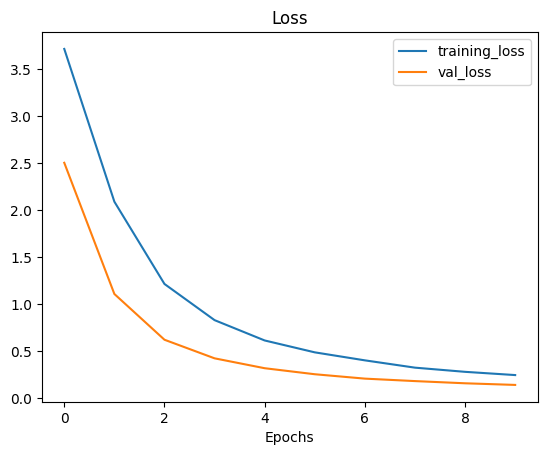

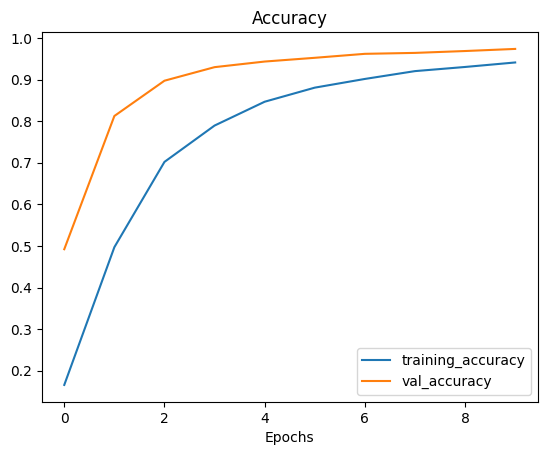

In [21]:
plot_loss_curves(history)

### Making predictions on the Test Data

In [22]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['Mentha (Mint)', 'Amaranthus Viridis (Arive-Dantu)', 'Jatropha Gossypiifolia (Bellyache bush)', 'Artemisia Indica (Indian wormwood)', 'Coleus Amboinicus (Mexican Mint)']


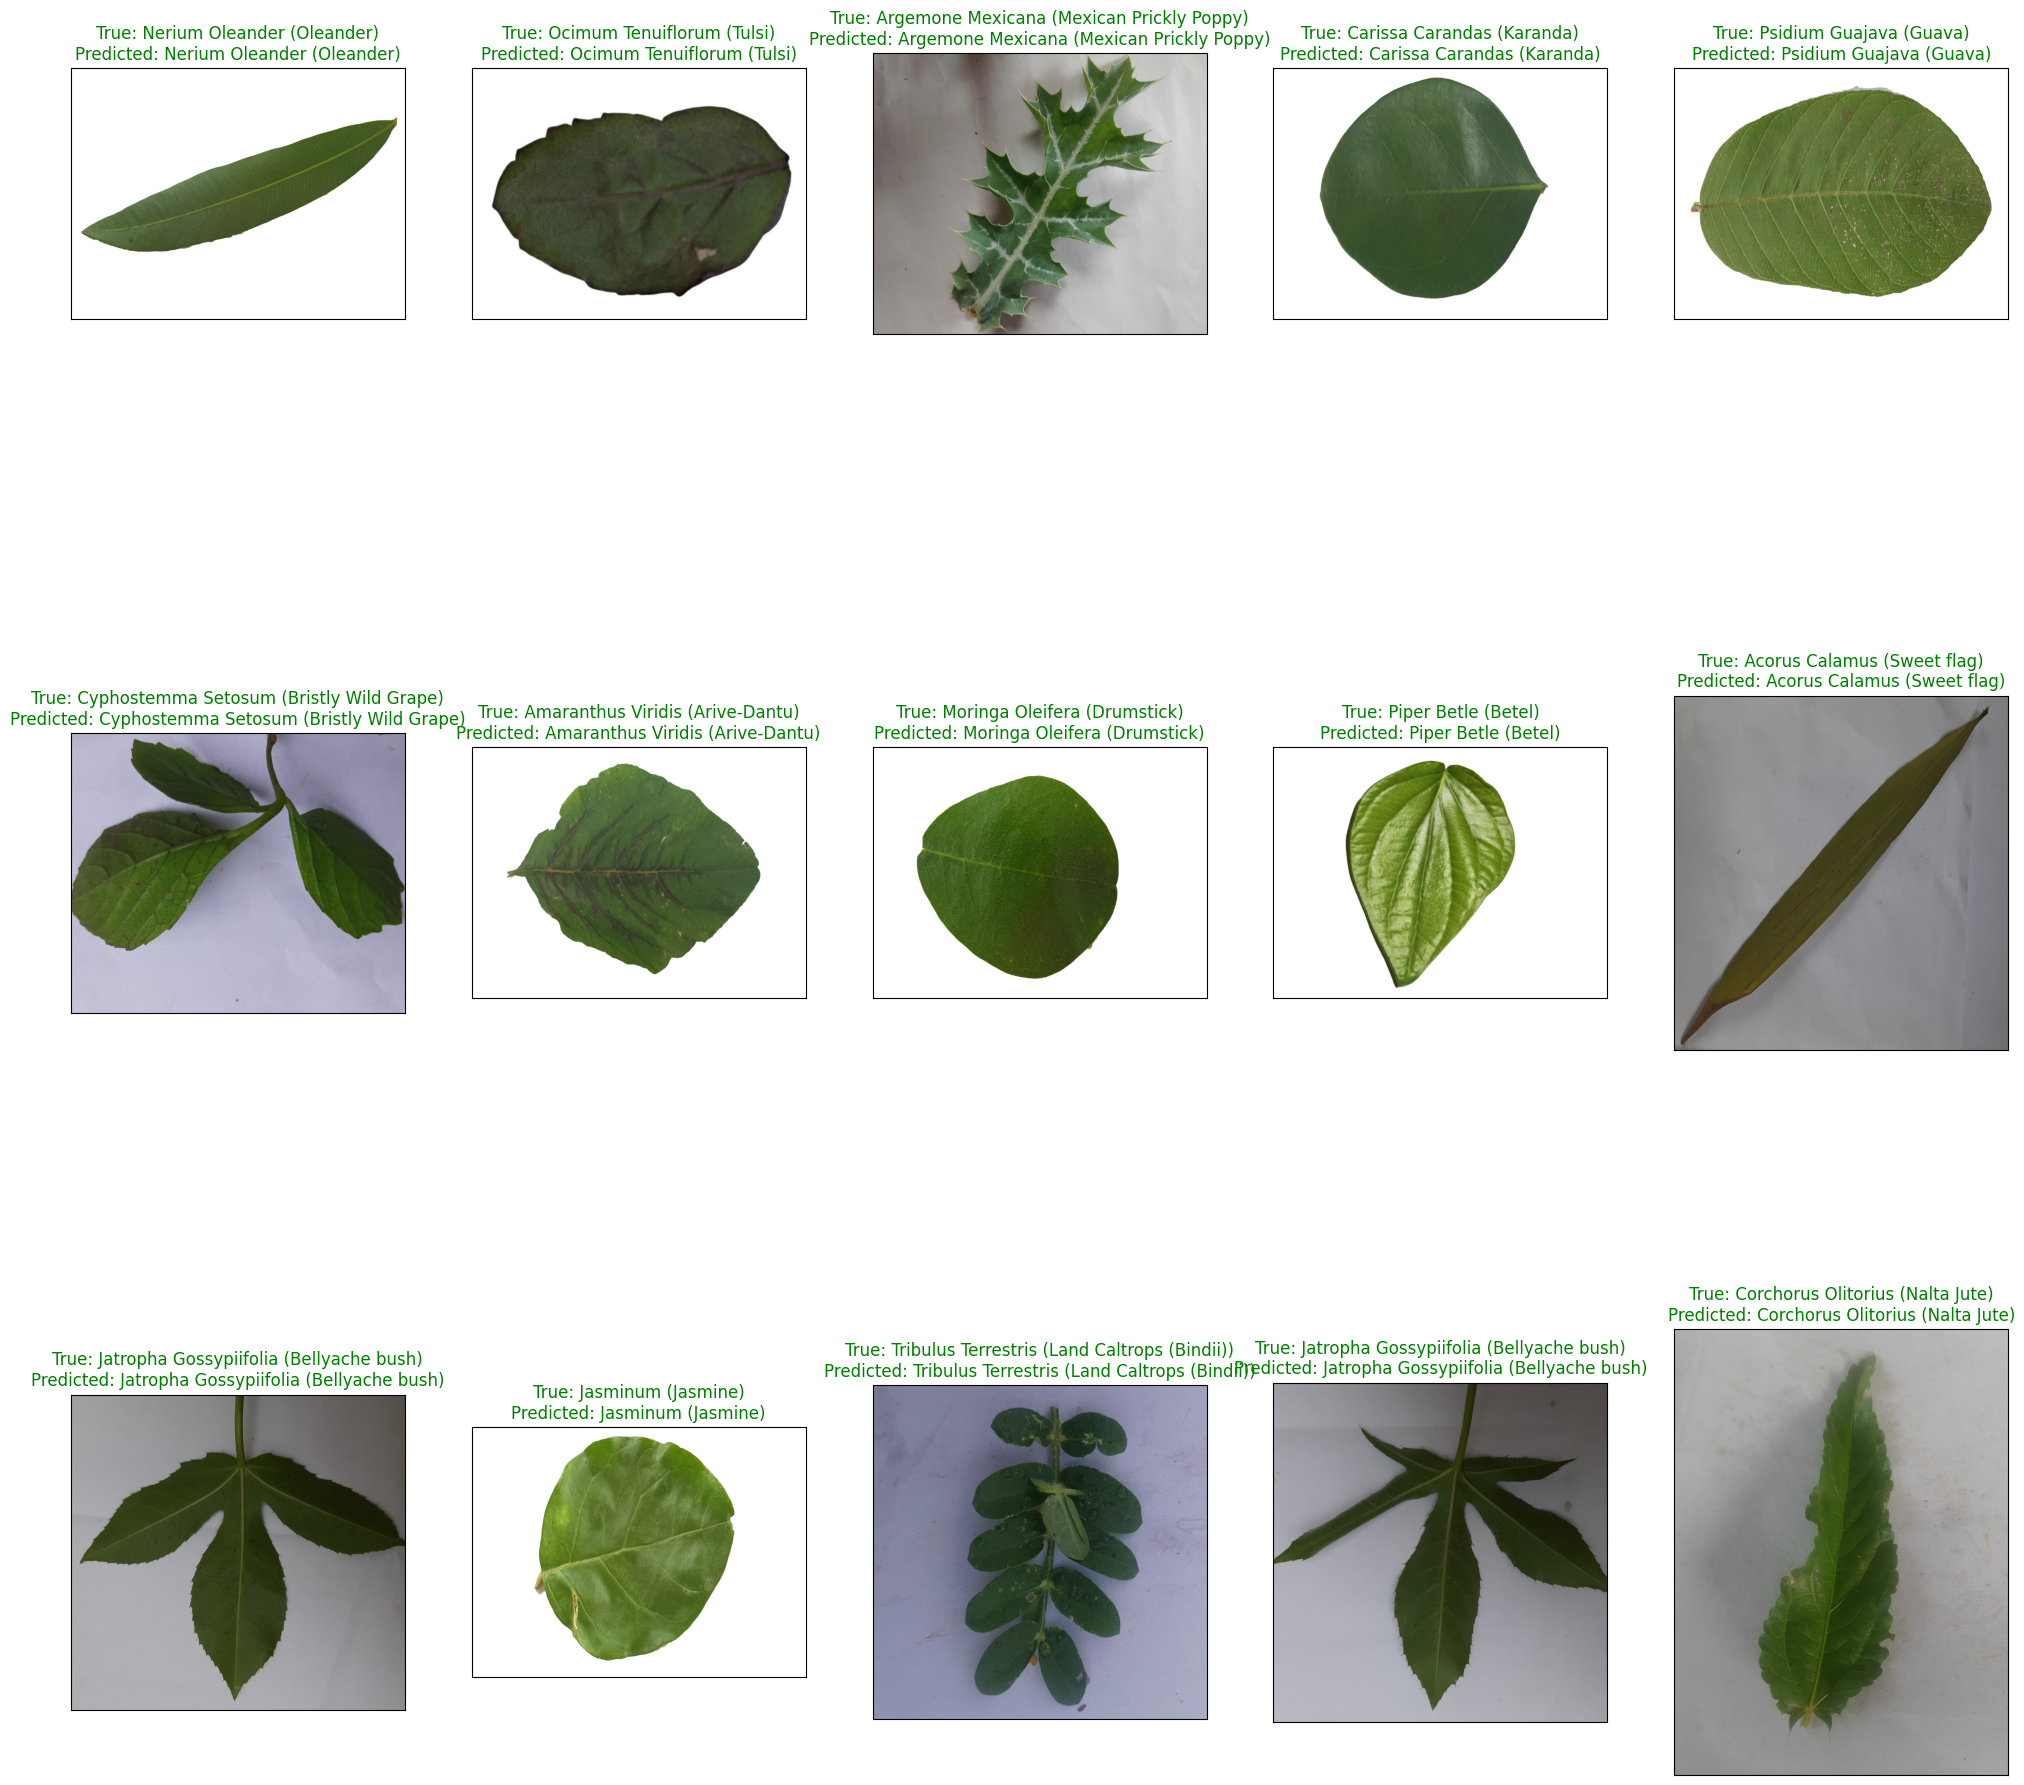

<Figure size 640x480 with 0 Axes>

In [23]:
# Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25,25),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

### Plotting the Classification Reports and Confusion Matrix

In [24]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                                                   precision    recall  f1-score   support

                   Abrus Precatorius (Rosary Pea)       0.92      0.97      0.94        35
              Acalypha Indica (Indian CopperLeaf)       0.91      1.00      0.95        48
        Achyranthes Aspera (Prickly Chaff Flower)       1.00      0.93      0.97        15
                      Acorus Calamus (Sweet flag)       1.00      1.00      1.00        34
                Aerva Lanata (Mountain Knotgrass)       0.88      1.00      0.93        28
                          Alpinia Galanga (Rasna)       1.00      1.00      1.00        24
                 Amaranthus Viridis (Arive-Dantu)       0.98      0.98      0.98        58
          Andrographis Paniculata (Green Chireta)       0.97      0.94      0.95        32
          Anisomeles Malabarica (Malabar Catmint)       0.89      1.00      0.94        17
        Argemone Mexicana (Mexican Prickly Poppy)       1.00      1.00      1.00        2

In [25]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
Abrus Precatorius (Rosary Pea),0.918919,0.971429,0.944444,35.00000
Acalypha Indica (Indian CopperLeaf),0.905660,1.000000,0.950495,48.00000
Achyranthes Aspera (Prickly Chaff Flower),1.000000,0.933333,0.965517,15.00000
Acorus Calamus (Sweet flag),1.000000,1.000000,1.000000,34.00000
Aerva Lanata (Mountain Knotgrass),0.875000,1.000000,0.933333,28.00000
...,...,...,...,...
Vitis Vinifera (Trellis Vine),1.000000,1.000000,1.000000,26.00000
Ziziphus Mauritiana (Indian Jujube),0.967742,0.937500,0.952381,32.00000
accuracy,0.964960,0.964960,0.964960,0.96496
macro avg,0.967344,0.966893,0.966144,2226.00000


### Checking for Random Images

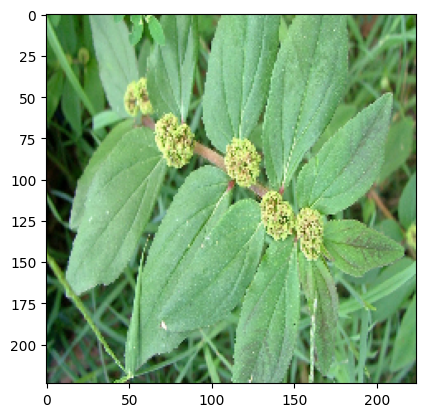

In [26]:
from keras.preprocessing import image
img = image.load_img(r"C:\Users\appud\Downloads\test_im3.jpg",target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)

In [27]:
y_pred=model.predict(tf.expand_dims(img,axis=0))
print(y_pred)
y_pred = np.argmax(y_pred,axis=1)
print(y_pred)

[[3.0221113e-03 2.8779937e-02 3.0900741e-03 9.8666083e-04 7.2799518e-04
  2.4916409e-02 1.0074308e-02 7.5834454e-03 7.1536277e-05 6.7501523e-02
  8.2508326e-03 3.1383270e-03 7.1749501e-03 8.6609070e-04 7.2076872e-02
  1.5136115e-03 1.5245144e-04 6.8763754e-04 1.3330839e-02 3.6294472e-03
  9.5962919e-03 1.0707661e-03 1.2720826e-02 7.1612350e-03 8.3371252e-03
  2.5675267e-02 1.6515192e-03 3.8009337e-03 4.0021739e-03 1.1458299e-03
  9.3115978e-03 2.0809697e-03 5.0607892e-03 2.6868198e-03 1.7910807e-03
  3.2452834e-03 3.4047000e-02 4.6421061e-03 2.7718768e-03 3.5242862e-03
  6.1610797e-03 3.0960657e-02 2.7642263e-02 1.1309015e-03 3.8302380e-03
  6.7817484e-04 1.4719210e-03 5.0142057e-02 3.8651880e-02 5.5642147e-03
  7.2060263e-04 6.9718319e-03 2.2496323e-03 3.2733873e-02 7.6571419e-03
  4.9891494e-02 2.4031166e-03 1.2037550e-02 1.7607412e-03 6.7653850e-04
  1.4926108e-04 1.2147145e-02 8.2032360e-02 7.0186155e-03 1.3435413e-02
  6.2599848e-03 5.1543885e-03 8.7134596e-03 1.1384705e-03 1.6015

In [28]:
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in y_pred]


pred
#plt.imshow(img)

['Senna Alexandrina (Tinnevelly Senna)']